In [127]:
using Revise
using LinearAlgebra

import JLD
import PyPlot; plt = PyPlot
import CMF; cmf = CMF

include("./sep_plot_settings.jl")

set_size

## Load data

- Songbird data from: https://cdn.elifesciences.org/articles/38471/elife-38471-v1.pdf

In [2]:
scipy_io = PyCall.pyimport("scipy.io")
matfile = scipy_io.loadmat("../../cmf_data/MackeviciusData.mat")

song = matfile["SONG"];

## Fit data

In [103]:
K = 3
L = 20
n_trials = 1

algorithms = Dict(
    "Mult" => Dict(
        :alg => :mult, :max_itr => 60
    ),
    "ANLS" => Dict(
        :alg => :anls, :max_itr => 25
    ),
    "ANLS-1" => Dict(
        :alg => :anls, :max_itr => 1
    ),
    "HALS" => Dict(
        :alg => :hals, :max_itr => 20
    )
)
seed = sum([Int(c) for c in "SEPARABLITY"])
sep_thresh=10;

In [63]:
rs = cmf.fit_cnmf(
    song, K=K, L=L,
    alg=:sep, thresh=sep_thresh
)
println("Error: ", rs.loss_hist[end])

0.7318612410208795


In [108]:
rsep = Dict()

for alg in keys(algorithms)
    W, H = rs.W, rs.H
    if alg == "Mult"
        W = W .+ sqrt(eps())
        H = H .+ sqrt(eps())
    end
    
    rsep[alg] = cmf.fit_cnmf(
        song; K=K, L=L, max_time=Inf,
        initW=W, initH=H, 
        algorithms[alg]...
    )
    println(alg, " error: ", rsep[alg].loss_hist[end])
end

Mult error: 0.5866765318608578


In [130]:
rrand = Dict()

for alg in keys(algorithms)
    for tr in 1:n_trials
        rrand[string(tr, alg)] = cmf.fit_cnmf(
            song; K=K, L=L, max_time=Inf,
            seed=seed*tr,
            algorithms[alg]...
        )
    end
    println(alg, " finished.")
end

Base.KeySet for a Dict{Any,Any} with 4 entries. Keys:
  "(1, \"Mult\")"
  "(1, \"HALS\")"
  "(1, \"ANLS\")"
  "(1, \"ANLS-1\")"

In [134]:
JLD.save("./sep_songbird.jld", "rs", rs, "rsep", rsep, "rrand", rrand)

## Plot results

In [141]:
jd = JLD.load("./sep_songbird.jld")
rs = jd["rs"]
rsep = jd["rsep"]
rrand = jd["rrand"];

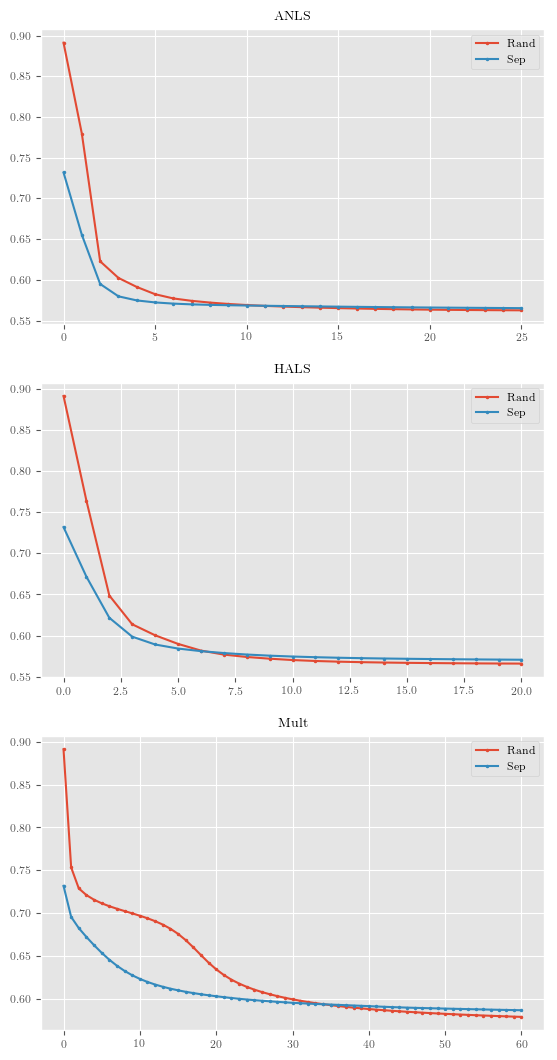

In [144]:
fig, axes = plt.subplots(3, 1, figsize=set_size(doc_textwidth, aspect=2))

for (i, alg) in enumerate(["ANLS", "HALS", "Mult"])
    axes[i].plot(rrand[string(1, alg)].loss_hist, label="Rand", markersize=3, marker=".")
    axes[i].plot(rsep[alg].loss_hist, label="Sep", markersize=3, marker=".")
    axes[i].set_title(alg)
    axes[i].legend()
end

plt.show()

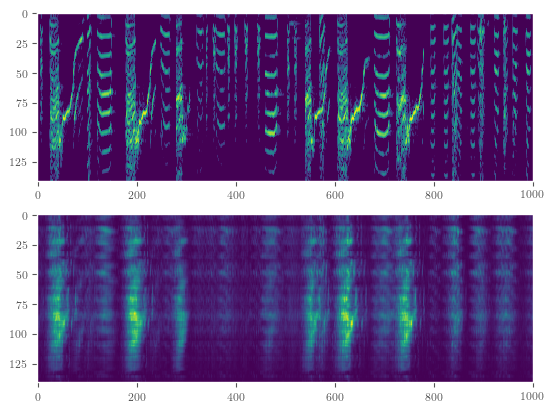

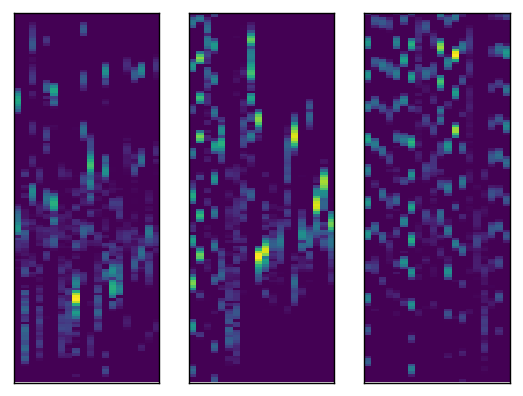

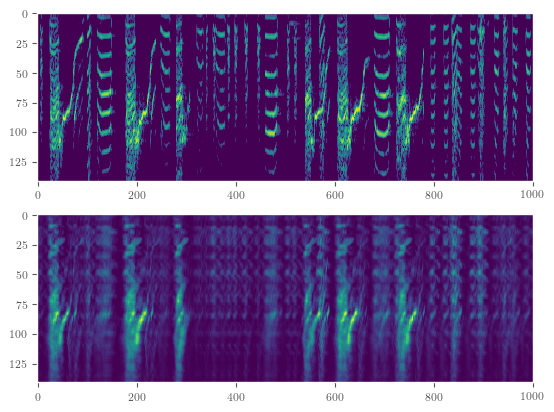

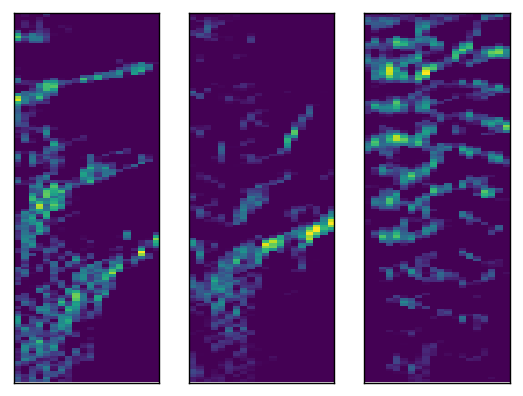

(PyPlot.Figure(PyObject <Figure size 640x480 with 3 Axes>), PyObject[PyObject <matplotlib.axes._subplots.AxesSubplot object at 0x7fe57a67b6a0>, PyObject <matplotlib.axes._subplots.AxesSubplot object at 0x7fe57e175e10>, PyObject <matplotlib.axes._subplots.AxesSubplot object at 0x7fe57b5e1f60>])

In [129]:
# Plot visual

cmf.plot_reconstruction(rs, 1000:2000, sort_units=false)
cmf.plot_Ws(rs, sort_units=false)

cmf.plot_reconstruction(rsep["ANLS-1"], 1000:2000, sort_units=false)
cmf.plot_Ws(rsep["ANLS-1"], sort_units=false)

## Supplemental

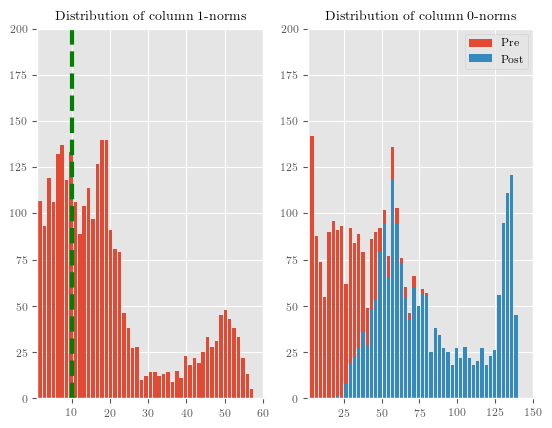

In [88]:
# Choice of threshold

function thresh(data, t)
    out = zeros(size(data))
    for j in 1:size(data, 2)
        if (sum(data[:, j]) > t)
            out[:, j] = data[:, j]
        end
    end
    return out
end

t = 10
songt = thresh(song, t)

powers1 = sum(song, dims=1)[1, :]
powers0_pre = sum(song .!= 0, dims=1)[1, :]
powers0_post = sum(songt .!= 0, dims=1)[1, :]

# Plot
plt.figure()

plt.subplot(1, 2, 1)
plt.hist(powers1, bins=50, rwidth=0.8)
plt.xlim([1, 60])
plt.ylim([0, 200])
plt.axvline(t, color="green", lw=3, ls="--")
plt.title("Distribution of column 1-norms")

plt.subplot(1, 2, 2)
plt.hist(powers0_pre, bins=50, rwidth=0.75, align="mid", label="Pre")
plt.hist(powers0_post, bins=50, rwidth=0.75, align="mid", label="Post")
plt.xlim([1.5, 150])
plt.ylim([0, 200])
plt.title("Distribution of column 0-norms")
plt.legend()

plt.show()